# Testing Xception

In [1]:
import tensorflow as tf
import data.imageReading as ir
from fairness import fairnessMetrics as fm
from model import model as m
from model import utils as utils
from model import biasMitigation as mit
from model import evaluation as ev
from tuning import callbacks as cb
import datetime
import os
import numpy as np

In [2]:
image_size = (299,299)
batch_size = 128
epochs = 20
#(ds_train, train_batches, ds_val, val_batches, ds_test, test_batches, count_classes) = ir.readData("/mimer/NOBACKUP/groups/snic2022-22-1091/museumFaces", image_size, batch_size, preprocess_input)
#(ffds_train, fftrain_batches, ffds_val, ffval_batches, ffds_test, fftest_batches, ffcount_classes) = ir.readData("/mimer/NOBACKUP/groups/snic2022-22-1091/FairFace", image_size, batch_size, preprocess_input)
(ds_train, train_batches, ds_val, val_batches, ds_test, test_batches, count_classes) = ir.readData("/mimer/NOBACKUP/groups/snic2022-22-1091/museumFaces_split", image_size, batch_size, None, False, False)
(ffds_train, fftrain_batches, ffds_val, ffval_batches, ffds_test, fftest_batches, ffcount_classes) = ir.readData("/mimer/NOBACKUP/groups/snic2022-22-1091/FairFace_split", image_size, batch_size, None, False, False)


Found 3916 images belonging to 2 classes.
Found 489 images belonging to 2 classes.
Found 492 images belonging to 2 classes.
Count classes: (2052, 1864, 256, 233, 258, 234)
Found 78158 images belonging to 2 classes.
Found 9769 images belonging to 2 classes.
Found 9771 images belonging to 2 classes.
Count classes: (36736, 41422, 4592, 5177, 4592, 5179)


## Find learning rate

In [ ]:
class_weight = mit.findClassWeights(train_batches)

strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = m.build_model(False, (299,299), "Xception")
    metric_list = m.metrics_list()

model.compile(optimizer=tf.keras.optimizers.Adam(), 
                           loss="binary_crossentropy", 
                           metrics="accuracy")


In [ ]:
epochs = 200
train_input = []
train_output = []
nr_batches = 10

model.fit(ds_train, steps_per_epoch=nr_batches, callbacks=[cb.LerningRateCallback(100, nr_batches)], epochs=epochs, verbose=2)

## Test Xception FairFace (unweighted) 

In [3]:
epochs = 20
class_weight = mit.findClassWeights(train_batches)

strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = m.build_model(False, (299,299), "Xception")
    metric_list = m.metrics_list()
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        1e-4,
        decay_steps=100000,
        decay_rate=0.96,
    )


model.compile(optimizer=tf.keras.optimizers.Adam(lr_schedule), 
                           loss="binary_crossentropy", 
                           metrics=metric_list)


utils.train_model(model, epochs, ffds_train, fftrain_batches, ffds_val, ffval_batches, None, False)

print("Make folder...")
dir_name = datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + "_Xception_FairFace"
os.mkdir(dir_name)

utils.saveModel(model, dir_name + "/Xception_FairFace.h5")

Weight for class 0: 0.95
Weight for class 1: 1.05
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:local

/apps/Arch/software/TensorFlow/2.7.1-foss-2021b-CUDA-11.4.1/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/20
INFO:tensorflow:batch_all_reduce: 158 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 158 all-reduces with algorithm = nccl, num_packs = 1
611/611 [==============================] - 713s 1s/step - loss: 0.6904 - accuracy: 0.6657 - true_positives: 28747.0000 - true_negatives: 23280.0000 - false_positives: 13456.0000 - false_negatives: 12675.0000 - true_positive_rate: 0.6940 - true_negative_rate: 0.6337 - false_positive_rate: 0.3663 - false_negative_rate: 0.3060 - positive_predicted_value: 0.6812 - false_discovery_rate: 0.3188 - negative_predicted_value: 0.6475 - false_omission_rate: 0.3525 - binary_demographic_parity_diff: 6248.0000 - demographic_parity: 42203.0000 - binary_equalized_odds_diff: -0.0603 - binary_proportional_parity_diff: 0.0799 - proportional_parity: 0.5400 - binary_predictive_rate_parity_diff: 0.0337 - predictive_rate_parity: 0.6812 - binary_accuracy_parity_diff: 0.3313 - accuracy_parity: 0.6657 - false_negative_rate_parity_

Epoch 5/20
611/611 [==============================] - 610s 999ms/step - loss: 0.2285 - accuracy: 0.9024 - true_positives: 37623.0000 - true_negatives: 32903.0000 - false_positives: 3833.0000 - false_negatives: 3799.0000 - true_positive_rate: 0.9083 - true_negative_rate: 0.8957 - false_positive_rate: 0.1043 - false_negative_rate: 0.0917 - positive_predicted_value: 0.9075 - false_discovery_rate: 0.0925 - negative_predicted_value: 0.8965 - false_omission_rate: 0.1035 - binary_demographic_parity_diff: 4754.0000 - demographic_parity: 41456.0000 - binary_equalized_odds_diff: -0.0126 - binary_proportional_parity_diff: 0.0608 - proportional_parity: 0.5304 - binary_predictive_rate_parity_diff: 0.0110 - predictive_rate_parity: 0.9075 - binary_accuracy_parity_diff: 0.8047 - accuracy_parity: 0.9024 - false_negative_rate_parity_diff: 0.0126 - false_positive_rate_parity_diff: -0.0126 - binary_negative_predictive_rate_parity_diff: -0.0110 - negative_predictive_rate_parity: 0.9075 - binary_specificity

Testing Model
-------------
Plot Histogram...


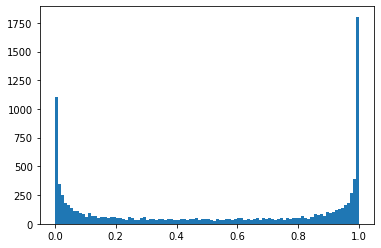

Plot ROC...


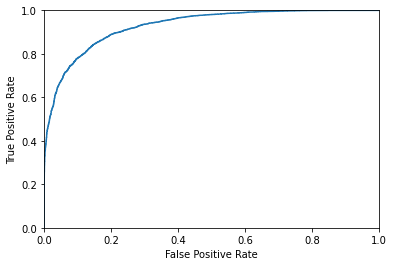

Plot Confusion matrix...


<Figure size 432x288 with 0 Axes>

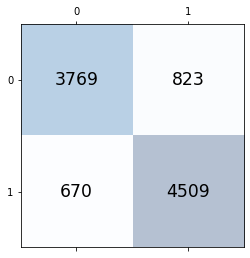

Plot Results...


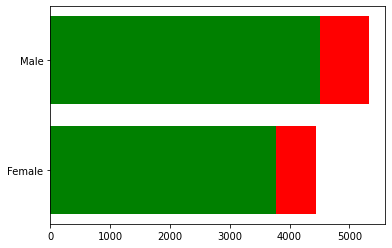


    Test results (Without threshold change):
    -------------
    
    Accuracy: 0.847
    
    True positives: 4509.000
    False positives: 823.000
    
    True negatives: 3769.000
    False negatives: 670.000
    
    Test results metrics:
    ---------------------
    True positive rate tp/(tp+fn): 0.871
    True negative rate tn/(tn+fp): 0.821
    
    False negative rate fn/(tp+fn): 0.129
    False positive rate fp/(tn+fp): 0.179
    
    Positive predicted value tp/(tp+fp): 0.846
    False discovery rate fp/(tp+fp): 0.154
    
    Negative predicted value tn/(tn+fn): 0.849
    False omission rate fn/(tn+fn): 0.151
    
    
    Binary demographic parity diff (tp+fp)-(tn+fn): 893.000
    Demographic parity tp+fp: 5332.000
    
    Binary equalized odds diff (tp/(tp+fn))-(tn/(tn+fp)): 0.050
    
    Binary proportional parity diff ((tp+fp)/(tp+fp+tn+fn))-((tn+fn)/(tp+fp+tn+fn)): 0.091
    Proportional parity (tp+fp)/(tp+fp+tn+fn): 0.546
    
    Binary predictive rate parity di

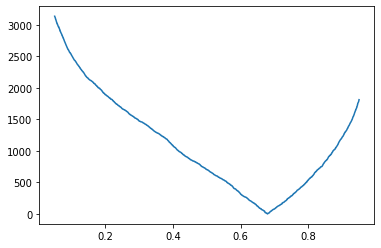

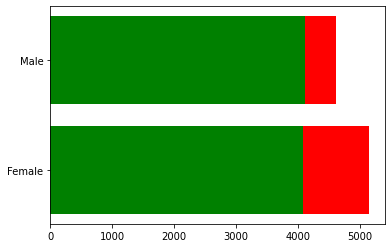


    Test results (Equal True):
    -------------
    
    Accuracy: 0.838
    
    True positives: 4107.000
    False positives: 514.000
    
    True negatives: 4078.000
    False negatives: 1072.000
    
    Test results metrics:
    ---------------------
    True positive rate tp/(tp+fn): 0.793
    True negative rate tn/(tn+fp): 0.888
    
    False negative rate fn/(tp+fn): 0.207
    False positive rate fp/(tn+fp): 0.112
    
    Positive predicted value tp/(tp+fp): 0.889
    False discovery rate fp/(tp+fp): 0.111
    
    Negative predicted value tn/(tn+fn): 0.792
    False omission rate fn/(tn+fn): 0.208
    
    
    Binary demographic parity diff (tp+fp)-(tn+fn): -529.000
    Demographic parity tp+fp: 4621.000
    
    Binary equalized odds diff (tp/(tp+fn))-(tn/(tn+fp)): -0.095
    
    Binary proportional parity diff ((tp+fp)/(tp+fp+tn+fn))-((tn+fn)/(tp+fp+tn+fn)): -0.054
    Proportional parity (tp+fp)/(tp+fp+tn+fn): 0.473
    
    Binary predictive rate parity diff (tp/(tp

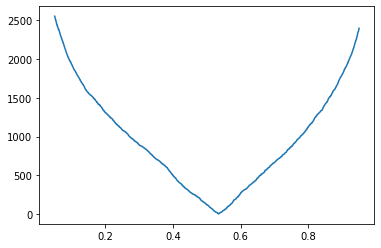

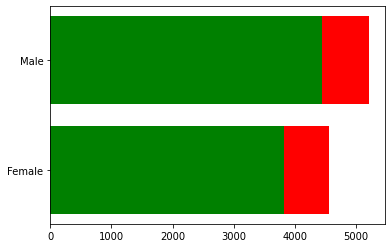


    Test results (Equal False):
    -------------
    
    Accuracy: 0.847
    
    True positives: 4449.000
    False positives: 764.000
    
    True negatives: 3828.000
    False negatives: 730.000
    
    Test results metrics:
    ---------------------
    True positive rate tp/(tp+fn): 0.859
    True negative rate tn/(tn+fp): 0.834
    
    False negative rate fn/(tp+fn): 0.141
    False positive rate fp/(tn+fp): 0.166
    
    Positive predicted value tp/(tp+fp): 0.853
    False discovery rate fp/(tp+fp): 0.147
    
    Negative predicted value tn/(tn+fn): 0.840
    False omission rate fn/(tn+fn): 0.160
    
    
    Binary demographic parity diff (tp+fp)-(tn+fn): 655.000
    Demographic parity tp+fp: 5213.000
    
    Binary equalized odds diff (tp/(tp+fn))-(tn/(tn+fp)): 0.025
    
    Binary proportional parity diff ((tp+fp)/(tp+fp+tn+fn))-((tn+fn)/(tp+fp+tn+fn)): 0.067
    Proportional parity (tp+fp)/(tp+fp+tn+fn): 0.534
    
    Binary predictive rate parity diff (tp/(tp+fp

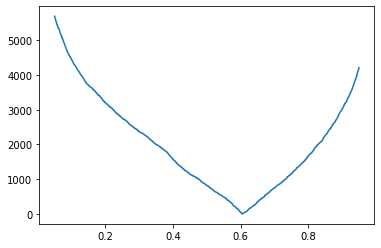

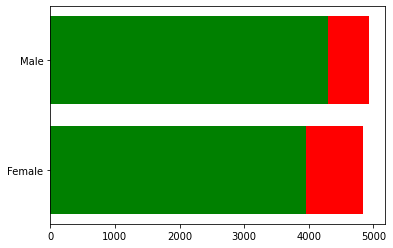


    Test results (Equal Total):
    -------------
    
    Accuracy: 0.844
    
    True positives: 4296.000
    False positives: 640.000
    
    True negatives: 3952.000
    False negatives: 883.000
    
    Test results metrics:
    ---------------------
    True positive rate tp/(tp+fn): 0.830
    True negative rate tn/(tn+fp): 0.861
    
    False negative rate fn/(tp+fn): 0.170
    False positive rate fp/(tn+fp): 0.139
    
    Positive predicted value tp/(tp+fp): 0.870
    False discovery rate fp/(tp+fp): 0.130
    
    Negative predicted value tn/(tn+fn): 0.817
    False omission rate fn/(tn+fn): 0.183
    
    
    Binary demographic parity diff (tp+fp)-(tn+fn): 101.000
    Demographic parity tp+fp: 4936.000
    
    Binary equalized odds diff (tp/(tp+fn))-(tn/(tn+fp)): -0.031
    
    Binary proportional parity diff ((tp+fp)/(tp+fp+tn+fn))-((tn+fn)/(tp+fp+tn+fn)): 0.010
    Proportional parity (tp+fp)/(tp+fp+tn+fn): 0.505
    
    Binary predictive rate parity diff (tp/(tp+f

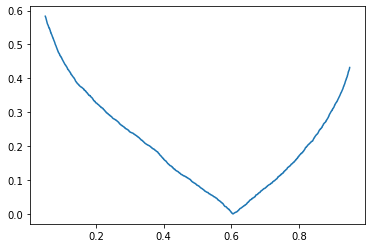

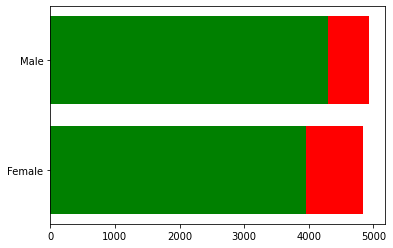


    Test results (Equal Odds):
    -------------
    
    Accuracy: 0.844
    
    True positives: 4296.000
    False positives: 640.000
    
    True negatives: 3952.000
    False negatives: 883.000
    
    Test results metrics:
    ---------------------
    True positive rate tp/(tp+fn): 0.830
    True negative rate tn/(tn+fp): 0.861
    
    False negative rate fn/(tp+fn): 0.170
    False positive rate fp/(tn+fp): 0.139
    
    Positive predicted value tp/(tp+fp): 0.870
    False discovery rate fp/(tp+fp): 0.130
    
    Negative predicted value tn/(tn+fn): 0.817
    False omission rate fn/(tn+fn): 0.183
    
    
    Binary demographic parity diff (tp+fp)-(tn+fn): 101.000
    Demographic parity tp+fp: 4936.000
    
    Binary equalized odds diff (tp/(tp+fn))-(tn/(tn+fp)): -0.031
    
    Binary proportional parity diff ((tp+fp)/(tp+fp+tn+fn))-((tn+fn)/(tp+fp+tn+fn)): 0.010
    Proportional parity (tp+fp)/(tp+fp+tn+fn): 0.505
    
    Binary predictive rate parity diff (tp/(tp+fp

<Figure size 432x288 with 0 Axes>

In [5]:
test_predict, test_labels, dir_name = ev.testModel(model, ffds_test, fftest_batches, dir_name)
ev.testModelWithThresholdChange(model, ffds_val, ffval_batches, test_predict, test_labels, dir_name)

# Fair face 2

In [3]:
epochs = 20
class_weight = mit.findClassWeights(train_batches)

strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = m.build_model(False, (299,299), "Xception")
    metric_list = m.metrics_list()
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        1e-4,
        decay_steps=100000,
        decay_rate=0.96,
    )


model.compile(optimizer=tf.keras.optimizers.Adam(lr_schedule), 
                           loss="binary_crossentropy", 
                           metrics=metric_list)


utils.train_model(model, epochs, ffds_train, fftrain_batches, ffds_val, ffval_batches, None, False)

print("Make folder...")
dir_name = datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + "_Xception_FairFace"
os.mkdir(dir_name)

utils.saveModel(model, dir_name + "/Xception_FairFace.h5")

Weight for class 0: 0.95
Weight for class 1: 1.05
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:local

/apps/Arch/software/TensorFlow/2.7.1-foss-2021b-CUDA-11.4.1/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/20
INFO:tensorflow:batch_all_reduce: 158 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 158 all-reduces with algorithm = nccl, num_packs = 1
611/611 [==============================] - 710s 1s/step - loss: 0.6005 - accuracy: 0.6940 - true_positives: 30003.0000 - true_negatives: 24241.0000 - false_positives: 12495.0000 - false_negatives: 11419.0000 - true_positive_rate: 0.7243 - true_negative_rate: 0.6599 - false_positive_rate: 0.3401 - false_negative_rate: 0.2757 - positive_predicted_value: 0.7060 - false_discovery_rate: 0.2940 - negative_predicted_value: 0.6798 - false_omission_rate: 0.3202 - binary_demographic_parity_diff: 6838.0000 - demographic_parity: 42498.0000 - binary_equalized_odds_diff: -0.0645 - binary_proportional_parity_diff: 0.0875 - proportional_parity: 0.5437 - binary_predictive_rate_parity_diff: 0.0262 - predictive_rate_parity: 0.7060 - binary_accuracy_parity_diff: 0.3881 - accuracy_parity: 0.6940 - false_negative_rate_parity_

Epoch 5/20
611/611 [==============================] - 610s 998ms/step - loss: 0.1487 - accuracy: 0.9404 - true_positives: 39097.0000 - true_negatives: 34406.0000 - false_positives: 2330.0000 - false_negatives: 2325.0000 - true_positive_rate: 0.9439 - true_negative_rate: 0.9366 - false_positive_rate: 0.0634 - false_negative_rate: 0.0561 - positive_predicted_value: 0.9438 - false_discovery_rate: 0.0562 - negative_predicted_value: 0.9367 - false_omission_rate: 0.0633 - binary_demographic_parity_diff: 4696.0000 - demographic_parity: 41427.0000 - binary_equalized_odds_diff: -0.0073 - binary_proportional_parity_diff: 0.0601 - proportional_parity: 0.5300 - binary_predictive_rate_parity_diff: 0.0071 - predictive_rate_parity: 0.9438 - binary_accuracy_parity_diff: 0.8809 - accuracy_parity: 0.9404 - false_negative_rate_parity_diff: 0.0073 - false_positive_rate_parity_diff: -0.0073 - binary_negative_predictive_rate_parity_diff: -0.0071 - negative_predictive_rate_parity: 0.9438 - binary_specificity

Testing Model
-------------
Instructions for updating:
use `experimental_local_results` instead.
Plot Histogram...


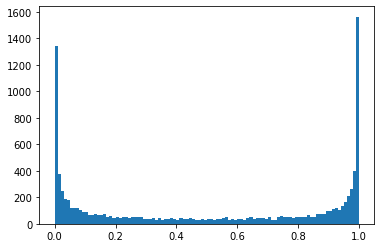

Plot ROC...


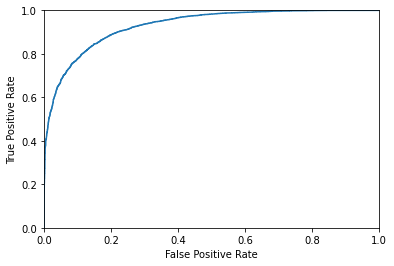

Plot Confusion matrix...


<Figure size 432x288 with 0 Axes>

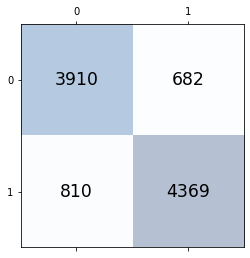

Plot Results...


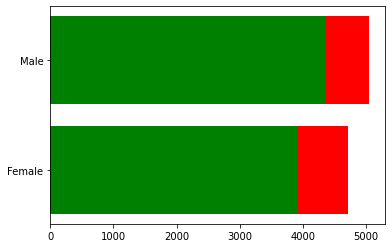


    Test results (Without threshold change):
    -------------
    
    Accuracy: 0.847
    
    True positives: 4369.000
    False positives: 682.000
    
    True negatives: 3910.000
    False negatives: 810.000
    
    Test results metrics:
    ---------------------
    True positive rate tp/(tp+fn): 0.844
    True negative rate tn/(tn+fp): 0.851
    
    False negative rate fn/(tp+fn): 0.156
    False positive rate fp/(tn+fp): 0.149
    
    Positive predicted value tp/(tp+fp): 0.865
    False discovery rate fp/(tp+fp): 0.135
    
    Negative predicted value tn/(tn+fn): 0.828
    False omission rate fn/(tn+fn): 0.172
    
    
    Binary demographic parity diff (tp+fp)-(tn+fn): 331.000
    Demographic parity tp+fp: 5051.000
    
    Binary equalized odds diff (tp/(tp+fn))-(tn/(tn+fp)): -0.008
    
    Binary proportional parity diff ((tp+fp)/(tp+fp+tn+fn))-((tn+fn)/(tp+fp+tn+fn)): 0.034
    Proportional parity (tp+fp)/(tp+fp+tn+fn): 0.517
    
    Binary predictive rate parity d

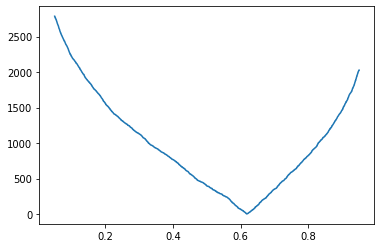

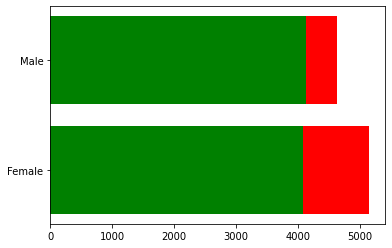


    Test results (Equal True):
    -------------
    
    Accuracy: 0.839
    
    True positives: 4118.000
    False positives: 508.000
    
    True negatives: 4084.000
    False negatives: 1061.000
    
    Test results metrics:
    ---------------------
    True positive rate tp/(tp+fn): 0.795
    True negative rate tn/(tn+fp): 0.889
    
    False negative rate fn/(tp+fn): 0.205
    False positive rate fp/(tn+fp): 0.111
    
    Positive predicted value tp/(tp+fp): 0.890
    False discovery rate fp/(tp+fp): 0.110
    
    Negative predicted value tn/(tn+fn): 0.794
    False omission rate fn/(tn+fn): 0.206
    
    
    Binary demographic parity diff (tp+fp)-(tn+fn): -519.000
    Demographic parity tp+fp: 4626.000
    
    Binary equalized odds diff (tp/(tp+fn))-(tn/(tn+fp)): -0.094
    
    Binary proportional parity diff ((tp+fp)/(tp+fp+tn+fn))-((tn+fn)/(tp+fp+tn+fn)): -0.053
    Proportional parity (tp+fp)/(tp+fp+tn+fn): 0.473
    
    Binary predictive rate parity diff (tp/(tp

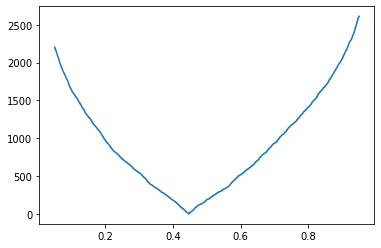

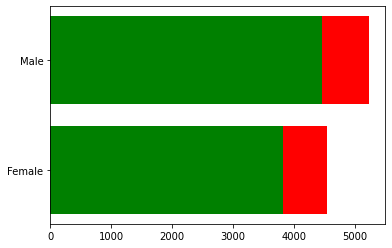


    Test results (Equal False):
    -------------
    
    Accuracy: 0.847
    
    True positives: 4459.000
    False positives: 774.000
    
    True negatives: 3818.000
    False negatives: 720.000
    
    Test results metrics:
    ---------------------
    True positive rate tp/(tp+fn): 0.861
    True negative rate tn/(tn+fp): 0.831
    
    False negative rate fn/(tp+fn): 0.139
    False positive rate fp/(tn+fp): 0.169
    
    Positive predicted value tp/(tp+fp): 0.852
    False discovery rate fp/(tp+fp): 0.148
    
    Negative predicted value tn/(tn+fn): 0.841
    False omission rate fn/(tn+fn): 0.159
    
    
    Binary demographic parity diff (tp+fp)-(tn+fn): 695.000
    Demographic parity tp+fp: 5233.000
    
    Binary equalized odds diff (tp/(tp+fn))-(tn/(tn+fp)): 0.030
    
    Binary proportional parity diff ((tp+fp)/(tp+fp+tn+fn))-((tn+fn)/(tp+fp+tn+fn)): 0.071
    Proportional parity (tp+fp)/(tp+fp+tn+fn): 0.536
    
    Binary predictive rate parity diff (tp/(tp+fp

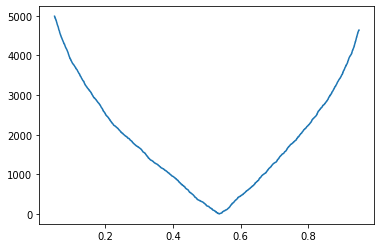

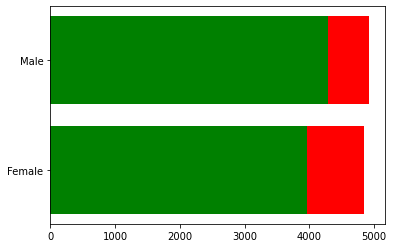


    Test results (Equal Total):
    -------------
    
    Accuracy: 0.845
    
    True positives: 4295.000
    False positives: 629.000
    
    True negatives: 3963.000
    False negatives: 884.000
    
    Test results metrics:
    ---------------------
    True positive rate tp/(tp+fn): 0.829
    True negative rate tn/(tn+fp): 0.863
    
    False negative rate fn/(tp+fn): 0.171
    False positive rate fp/(tn+fp): 0.137
    
    Positive predicted value tp/(tp+fp): 0.872
    False discovery rate fp/(tp+fp): 0.128
    
    Negative predicted value tn/(tn+fn): 0.818
    False omission rate fn/(tn+fn): 0.182
    
    
    Binary demographic parity diff (tp+fp)-(tn+fn): 77.000
    Demographic parity tp+fp: 4924.000
    
    Binary equalized odds diff (tp/(tp+fn))-(tn/(tn+fp)): -0.034
    
    Binary proportional parity diff ((tp+fp)/(tp+fp+tn+fn))-((tn+fn)/(tp+fp+tn+fn)): 0.008
    Proportional parity (tp+fp)/(tp+fp+tn+fn): 0.504
    
    Binary predictive rate parity diff (tp/(tp+fp

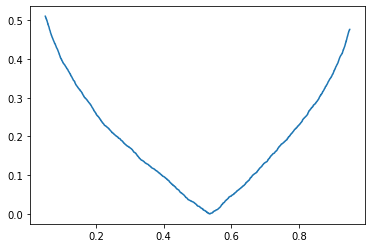

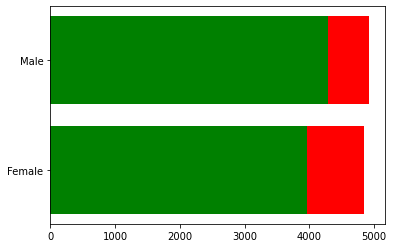


    Test results (Equal Odds):
    -------------
    
    Accuracy: 0.845
    
    True positives: 4295.000
    False positives: 629.000
    
    True negatives: 3963.000
    False negatives: 884.000
    
    Test results metrics:
    ---------------------
    True positive rate tp/(tp+fn): 0.829
    True negative rate tn/(tn+fp): 0.863
    
    False negative rate fn/(tp+fn): 0.171
    False positive rate fp/(tn+fp): 0.137
    
    Positive predicted value tp/(tp+fp): 0.872
    False discovery rate fp/(tp+fp): 0.128
    
    Negative predicted value tn/(tn+fn): 0.818
    False omission rate fn/(tn+fn): 0.182
    
    
    Binary demographic parity diff (tp+fp)-(tn+fn): 77.000
    Demographic parity tp+fp: 4924.000
    
    Binary equalized odds diff (tp/(tp+fn))-(tn/(tn+fp)): -0.034
    
    Binary proportional parity diff ((tp+fp)/(tp+fp+tn+fn))-((tn+fn)/(tp+fp+tn+fn)): 0.008
    Proportional parity (tp+fp)/(tp+fp+tn+fn): 0.504
    
    Binary predictive rate parity diff (tp/(tp+fp)

<Figure size 432x288 with 0 Axes>

In [4]:
test_predict, test_labels, dir_name = ev.testModel(model, ffds_test, fftest_batches, dir_name)
ev.testModelWithThresholdChange(model, ffds_val, ffval_batches, test_predict, test_labels, dir_name)